# AIRCRAFT FUEL CONSUMPTION MODELING
+ Author: Dinh Quang-Dung

+ Instructor: Jérôme Lacaille

In [ ]:
'''
    Changelog 19/1:
        1. Normalize data, make a correlation matrix between the variables 
        2. Try out linear regression on the dataset generated by get_consumption(), identifying the important features.
        3. Validate if the model is suitable
        4. Make plots
'''

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tabata as tbt
from tabata import Opset
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
from utils import get_consumption, detect_phase
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
datadir = os.getcwd()

In [3]:
# Reading the database by Opset() class
# Each .h5 files contains a number of flight info recordings of an aircraft
ac1 = Opset('Aircraft_01.h5')
ac2 = Opset('Aircraft_02.h5')
ac3 = Opset('Aircraft_03.h5')

In [4]:
#View a dataset 
ac1[2].head(5)

,ALT [ft],EGT_1 [deg C],EGT_2 [deg C],FMV_1 [mm],FMV_2 [mm],HPTACC_1 [%],HPTACC_2 [%],M [Mach],N1_1 [% rpm],N1_2 [% rpm],...,VIB_AN1_1 [mils],VIB_AN1_2 [mils],VIB_AN2_1 [ips],VIB_AN2_2 [ips],VIB_BN1_1 [mils],VIB_BN1_2 [mils],VIB_BN2_1 [ips],VIB_BN2_2 [ips],VSV_1 [mm],VSV_2 [mm]
record_02,,,,,,,,,,,,,,,,,,,,,
0,-32.456484,32.509804,35.465241,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
1,-32.456484,32.509804,35.465241,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
2,-32.456484,32.509804,34.480095,-0.726222,-0.64913,34.361312,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
3,-32.456484,32.509804,34.480095,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
4,-32.456484,32.509804,34.480095,-0.645530,-0.64913,34.361312,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748


In [7]:
#Double plot to visualize the variables
from ipywidgets import interact, widgets

def mydoubleplot(varname, record):
    df = ac1[record]
    tbt.doubleplot(df[varname], df["Q_1 [lb/h]"], title="Vol {}".format(record))

interact(mydoubleplot, varname=ac1.df.columns, record=widgets.IntSlider(0,0,len(ac1)-1,1)) ; #range(len(ac1))) ;

interactive(children=(Dropdown(description='varname', options=('ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', '…

# LINEAR REGRESSION

### TAXI1 phase

In [52]:
all_phases = ['taxi1','climb','cruise','descend','taxi2']
phase = 'taxi1'
dfc1 = get_consumption(ac1, phase)
dfc2 = get_consumption(ac2, phase)
dfc3 = get_consumption(ac3, phase)
dft = pd.concat([dfc1,dfc2,dfc3])

Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519


Select dfc1

In [98]:
df = dfc1[dfc1['ENG'] == 'Left'].drop(columns = ['Flight', 'AC', 'ENG', 'Volume'])
df.index = np.arange(len(df))
var_names = df.columns
df.head(5)

,Duration,Alt_max,Alt_slope,Avg_egt,TAT_max,TAT_min,T_oil_range,M_max,Weight
0,0.228611,39439.264501,0.640898,0.039437,862.015543,40.814093,-22.163944,59.739683,116.610233
1,0.176667,39457.811063,0.649114,0.029161,816.434746,40.543801,-20.271900,53.339003,82.690332
2,0.264444,40825.620025,0.624464,0.029223,1022.816007,32.164749,-29.191536,68.807313,191.529825
3,0.170833,42012.600005,0.632681,0.075393,911.275673,34.597377,-31.083580,59.739683,112.828014
4,0.197500,33629.553895,0.599814,0.045649,902.299125,19.461024,-21.893652,66.673753,138.199991


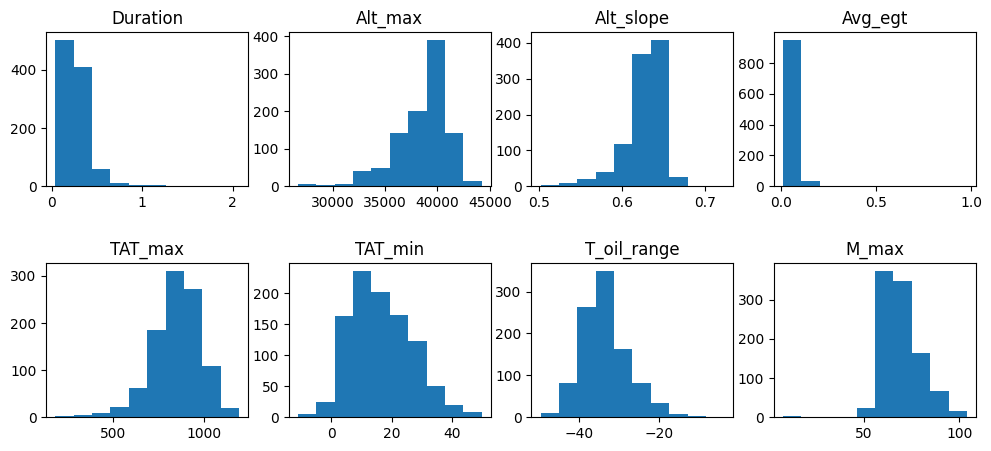

In [62]:
plt.figure(figsize=(12,5))
i = 0 
for col in df.columns[:-1]:
    i+=1
    plt.subplot(2,4,i)
    plt.hist(df[col])
    plt.title(col)
plt.subplots_adjust(hspace=0.5)

Most of the features are skewed so we may only normalize the data to interval [0,1] by MinMaxScaler

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df.drop(columns = ['Weight']))
df_transformed = scaler.transform(df.drop(columns = ['Weight']))
df_transformed = pd.DataFrame(df_transformed)
df_transformed = pd.concat([df_transformed,df['Weight']],axis=1)
df_transformed.columns = df.columns
df_transformed.head(5)

,Duration,Alt_max,Alt_slope,Avg_egt,TAT_max,TAT_min,T_oil_range,M_max,Weight
0,0.092154,0.726889,0.629630,0.030415,0.674131,0.853333,0.600000,0.541436,116.610233
1,0.066548,0.727945,0.666667,0.019805,0.629047,0.848889,0.641176,0.475138,82.690332
2,0.109818,0.805864,0.555556,0.019868,0.833179,0.711111,0.447059,0.635359,191.529825
3,0.063672,0.873481,0.592593,0.067540,0.722854,0.751111,0.405882,0.541436,112.828014
4,0.076818,0.395932,0.444444,0.036829,0.713976,0.502222,0.605882,0.613260,138.199991


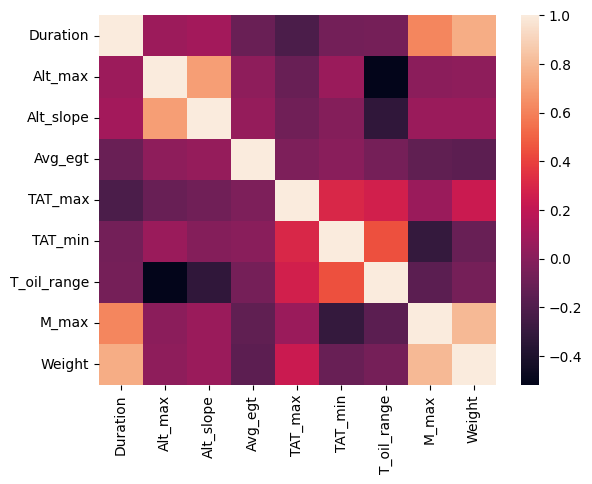

In [111]:
ax = sns.heatmap(df_transformed.corr())

We can see that there are some variable tht are strongly correlated such as `M_max` and `Weight`, some are quite correlated such as `TAT_max` and `TAT_min`

In [182]:
model = smf.ols("Weight~Duration + Alt_max+Alt_slope+Avg_egt+TAT_max+TAT_min+T_oil_range+M_max", data = df_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     722.1
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:08:20   Log-Likelihood:                -4915.1
No. Observations:                 995   AIC:                             9848.
Df Residuals:                     986   BIC:                             9892.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -256.2476     12.924    -19.827      

The p-values of `Alt_max`, `Alt_slope`, `Avg_egt`, `TAT_min` and `T_oil_range` is much higher than the significant level 0.05, therefore we accept the hypothesis that these features does not contributes to the prediction of `Weight` for the taxi phase. This is quite logic because the taxi phase is the phase when the airplane moves inside the airport.

In [183]:
model = smf.ols("Weight~Duration + TAT_max +M_max", data = df_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1874.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:09:01   Log-Likelihood:                -4928.8
No. Observations:                 995   AIC:                             9866.
Df Residuals:                     991   BIC:                             9885.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -285.8456      8.689    -32.898      0.0

Checking the distribution of the residuals of the model, they demonstrated a gaussian distribution with low variance, so we can say that the model with these three predictors is suitable for the task. A normal test by D'Agostino and Pearson were conducted using `scipy.stats.normaltest` which compares the skewness and kurtosis of the residuals with a normal distribution. It returns a very small p-values, reinforcing this observation.

In [190]:
scipy.stats.normaltest(res.resid_pearson)

NormaltestResult(statistic=487.53318355431304, pvalue=1.3599229996114227e-106)

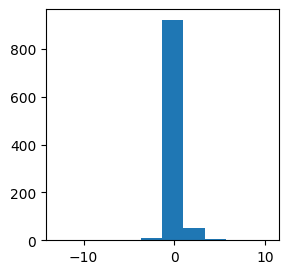

In [194]:
plt.figure(figsize=(3,3))
plt.hist(res.resid_pearson)
plt.show()

We want to visualize the `Weight` with respect to the two principal components obtained by PCA

In [187]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df_transformed[['Duration', 'TAT_max', 'M_max']])
df_pca = pca.transform(df_transformed[['Duration', 'TAT_max', 'M_max']])
pca.explained_variance_ratio_

array([0.54194895, 0.38700559, 0.07104546])

In [205]:
df_visualize = pd.concat([pd.Series(df_pca[:,0]),pd.Series(df_pca[:,1]),df_transformed['Weight']],axis = 1)
df_visualize.columns = ['PC1', 'PC2', 'Weight']

In [206]:
import plotly.express as px
fig = px.scatter_3d(df_visualize, x='PC1', y='PC2', z='Weight')
fig.show()

Next we plot a confidence interval for the residuals

In [223]:
w = 100 # Considering a range of 100 liters
target = df_transformed['Weight']
residual = res.resid.to_numpy()
st = np.zeros(len(target))
for i in range(len(target)):
    j = np.argwhere(np.abs(target-target.iloc[i])<=w)
    st[i] = np.std(residual[j])

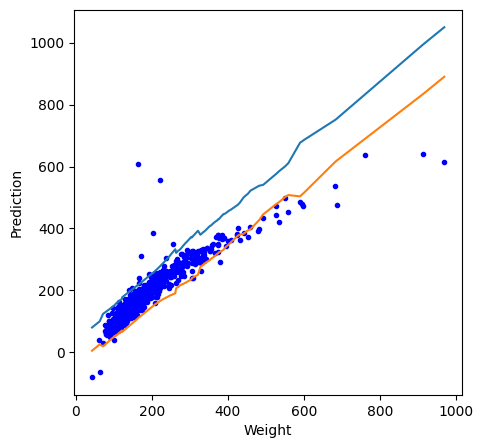

In [225]:
plt.figure(figsize=(5,5))

index = np.argsort(target)
plt.plot(target[index], res.predict()[index],'b.')
plt.plot(target[index], target[index]+1.96*st[index])
plt.plot(target[index], target[index]-1.96*st[index])
plt.xlabel('Weight')
plt.ylabel('Prediction')
plt.show()

In [172]:
# from sklearn.linear_model import LinearRegression, Lasso
# lm = Lasso(alpha = 0.1, fit_intercept= True, max_iter=10000)
# lm.fit(df_transformed.drop(columns = ['Weight']), df_transformed['Weight'])
# lm.coef_
# lm.score(df_transformed.drop(columns = ['Weight']), df_transformed['Weight'])

0.8533191430929645

In [86]:
# #Plot the consumption
# import plotly.express as px
# fig = px.scatter(dft, x="Duration", y="Total_weight", color="AC", symbol="ENG", 
#            hover_data=dict(AC=True, ENG=True, Flight=True, Duration=False, Total_weight=False), 
#            opacity=0.4,
#            title="Consommation en fonction de la durée de vol",
#            labels={"Conso" : "Consommation (litres)", "Leg" : "Durée du vol (heures)"})
# fig.update_traces(marker=dict(size=12))

# DECISION TREE

In [226]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [16]:
all_phases = ['taxi1','climb','cruise','descend','taxi2']
phase = 'taxi2'
dfc1 = get_consumption(ac1, phase)
dfc2 = get_consumption(ac2, phase)
dfc3 = get_consumption(ac3, phase)
dft = pd.concat([dfc1,dfc2,dfc3])

Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519


In [17]:
var = ['Flight', 'Duration', 'Alt_max', 'Slope', 'M_max', 'Volume']
X = dfc1[var]
y = dfc1['Weight']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=10)

In [19]:
reg1 = DecisionTreeRegressor(random_state=10)
reg2 = DecisionTreeRegressor(random_state=10, ccp_alpha=1)
reg3 = DecisionTreeRegressor(random_state=10, ccp_alpha=10,max_depth=4)
models = [reg1, reg2, reg3]
i=0
for reg in models:
    i+=1
    print(f'Params {i}')
    n_splits = 10
    fold = KFold(n_splits=n_splits)
    splits = fold.split(X,y)
    kfold_r2 = 0
    kfold_mse = 0
    for train_idx, test_idx in splits:
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        reg.fit(X_train,y_train)
        r2 = reg.score(X_test,y_test)
        mse = mean_squared_error(y_test,reg.predict(X_test))
        kfold_r2 += r2
        kfold_mse += mse
    kfold_r2 /= n_splits
    kfold_mse /= n_splits
    print('kfold R2 score: ', kfold_r2 , ', Residual: ',kfold_mse )

Params 1
kfold R2 score:  0.654282308234333 , Residual:  170.6624053413712
Params 2
kfold R2 score:  0.722694394437437 , Residual:  143.033582254157
Params 3
kfold R2 score:  0.8848716250486968 , Residual:  100.0965879449587


In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
pca = PCA(n_components= 4)
X_pca = pca.fit_transform(X_st,y)
pca.explained_variance_ratio_

reg1 = DecisionTreeRegressor(random_state=10)
reg2 = DecisionTreeRegressor(random_state=10, ccp_alpha=0.1)
reg3 = DecisionTreeRegressor(random_state=10, ccp_alpha=10,max_depth=5)
models = [reg1, reg2, reg3]
i=0
for reg in models:
    i+=1
    print(f'Params {i}')
    n_splits = 10
    fold = KFold(n_splits=n_splits)
    splits = fold.split(X_pca,y)
    kfold_r2 = 0
    kfold_mse = 0
    for train_idx, test_idx in splits:
        X_train, X_test, y_train, y_test = X_pca[train_idx], X_pca[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        reg.fit(X_train,y_train)
        r2 = reg.score(X_test,y_test)
        mse = mean_squared_error(y_test,reg.predict(X_test))
        kfold_r2 += r2
        kfold_mse += mse
    kfold_r2 /= n_splits
    kfold_mse /= n_splits
    print('kfold R2 score: ', kfold_r2 , ', Residual: ',kfold_mse )

Params 1
kfold R2 score:  0.34256290258798766 , Residual:  366.5522338485066
Params 2
kfold R2 score:  0.36073559863635835 , Residual:  353.50727226994115
Params 3
kfold R2 score:  0.348741136151081 , Residual:  340.65624796887505


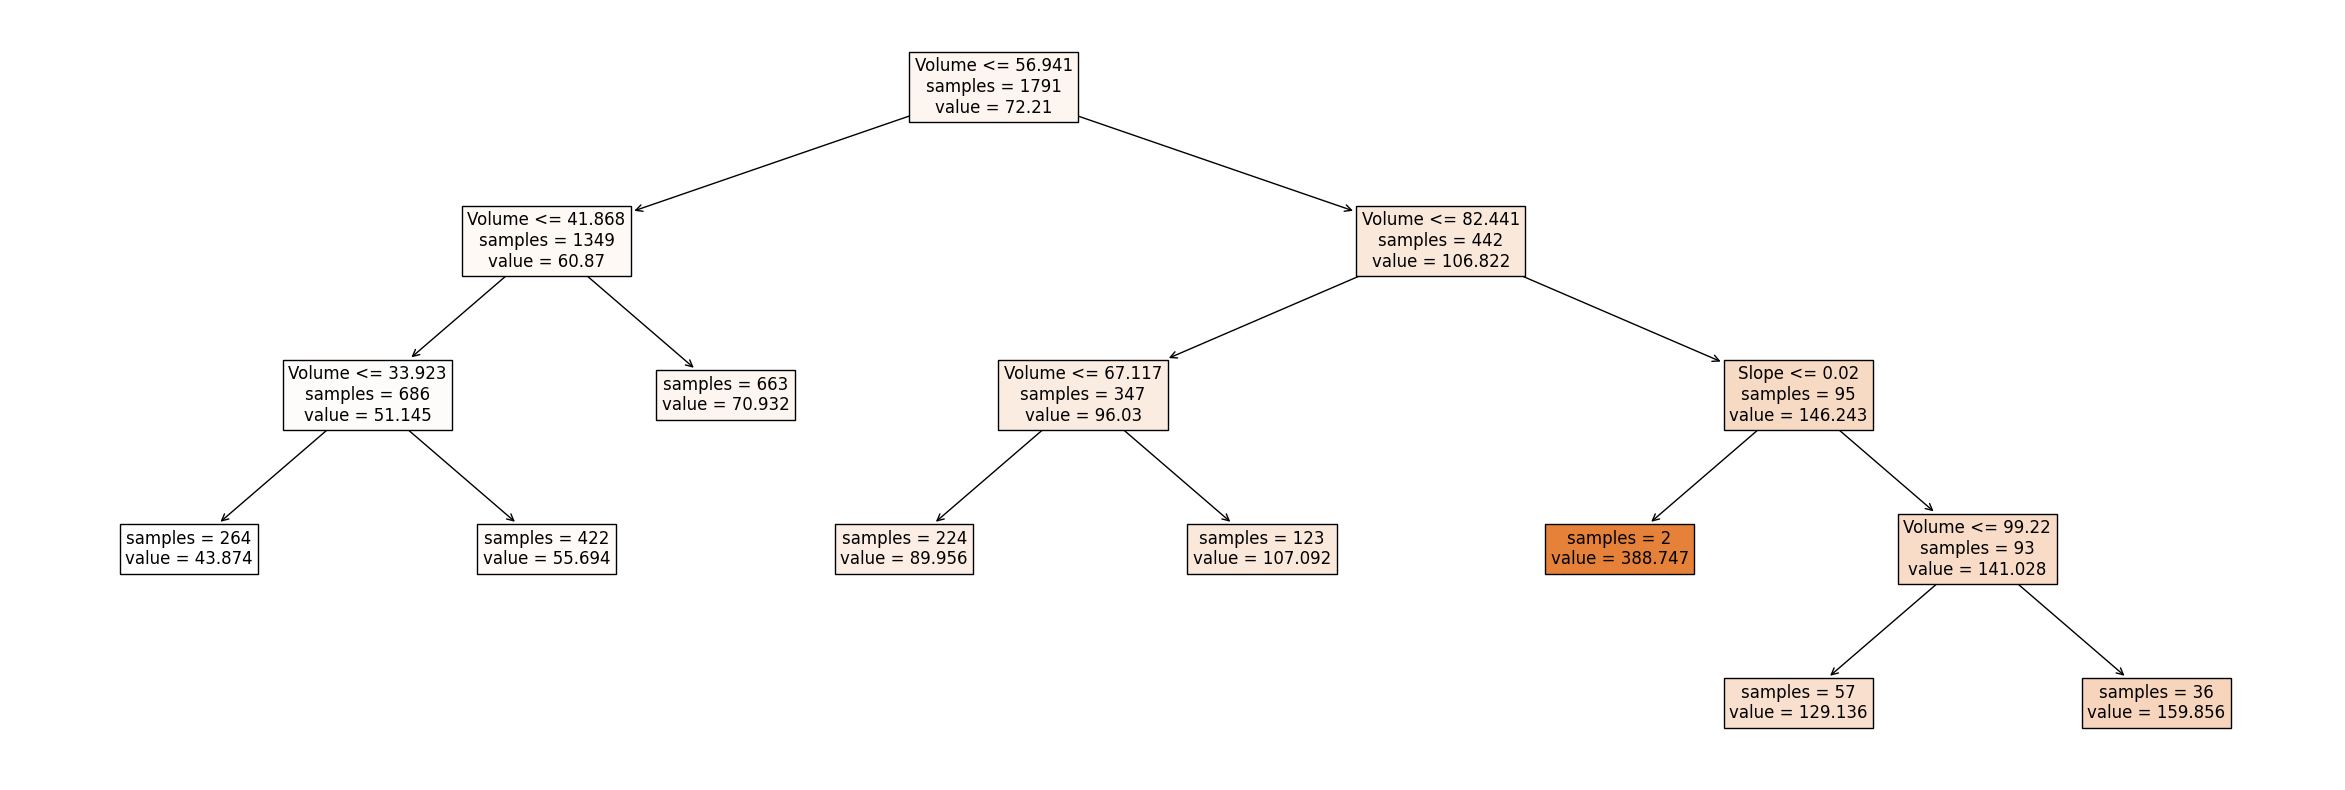

In [20]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(reg, 
                   feature_names=X.columns,
                   filled=True,fontsize=12,impurity=False)

# ===== DRAFT ===== 

phat hien sudden trend 900
phat hien sudden trend 1200
phat hien sudden trend 1500
phat hien sudden trend 1800
phat hien sudden trend 2100


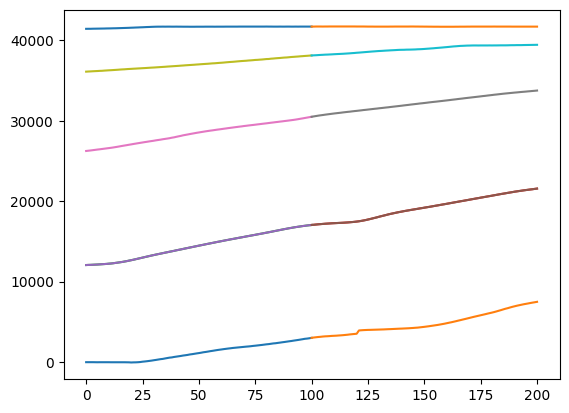

In [ ]:
cac_moc = [i*300 for i in range(1,30)]
k = 529
j = 0
cai_nao = 3
for moc in cac_moc:
    truoc = ac1[k]['ALT [ft]'].loc[moc:moc+100]
    sau = ac1[k]['ALT [ft]'].loc[moc+100:moc+200]
    slope_truoc, slope_sau = np.polyfit(x = np.arange(0,101),y = truoc,deg= 1)[0],np.polyfit(x = np.arange(0,101),y = sau,deg= 1)[0]
    if np.abs(slope_truoc) > 0.4:
        print('phat hien sudden trend',moc)
        plt.plot(np.arange(0,101),truoc)
        plt.plot(np.arange(100,201),sau)
        if j == cai_nao:
            plt.plot(np.arange(0,101),truoc)
            plt.plot(np.arange(100,201),sau)
    j+=1
        

8.215322644967223

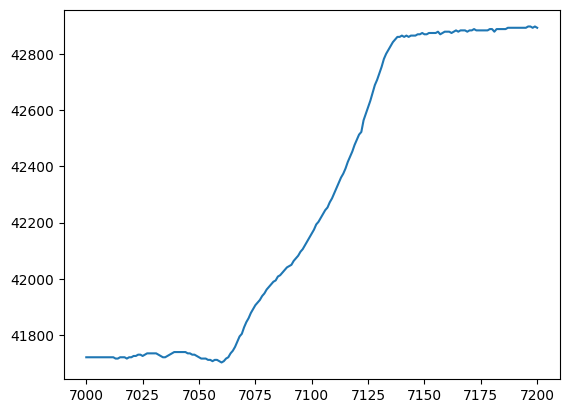

In [ ]:
plt.plot(ac1[k].iloc[7000:7201,0])
np.polyfit(x = np.arange(0,201),y = ac1[k].iloc[7000:7201,0],deg= 1)[0]

((0, 1167), (1167, 2522), (2522, 4942), (4942, 6408), (6408, 7085))
0 1167
1167 2522
2522 4942
4942 6408
6408 7085


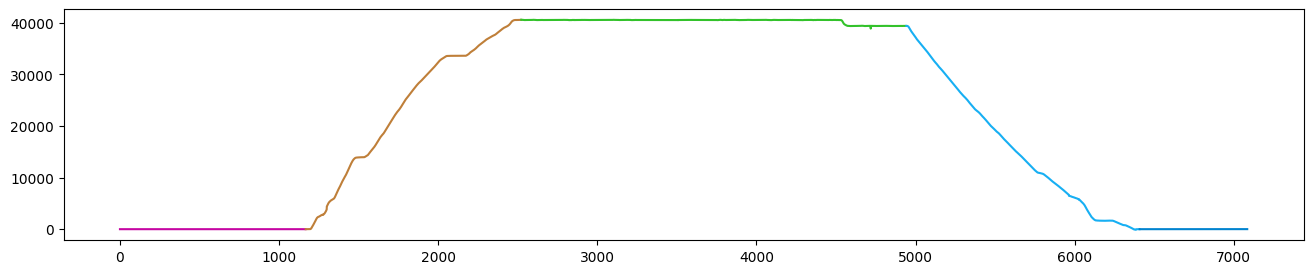

In [241]:
from utils import get_consumption, detect_phase
def color_plot(df,breaks):
    np.random.seed(10)
    for (start,end) in breaks:
        plt.plot(np.arange(start,end),df.iloc[start:end,0],color = np.random.rand(3))
        
# k = 234
# k = 291
k = 295
a = ac1[k]['ALT [ft]']
cruise_pos = a.idxmax()
breaks = detect_phase(ac1[k],look = 100, threshold=0.025)
print(breaks)

plt.figure(figsize=(16,3))
np.random.seed(10)
for (start,end) in breaks:
    print(start,end)
    plt.plot(np.arange(start,end),ac1[k].iloc[start:end,0],color = np.random.rand(3))


((0, 1167), (1167, 2394), (2394, 4968), (4968, 6408), (6408, 7085))
0 1167
1167 2394
2394 4968
4968 6408
6408 7085


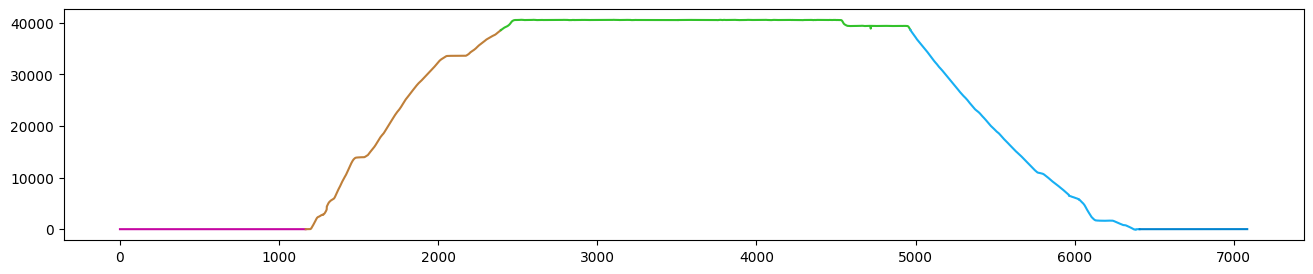

In [224]:
from utils import get_consumption, detect_phase
def color_plot(df,breaks):
    np.random.seed(10)
    for (start,end) in breaks:
        plt.plot(np.arange(start,end),df.iloc[start:end,0],color = np.random.rand(3))
        
# k = 234
# k = 291
k = 295
a = ac1[k]['ALT [ft]']
cruise_pos = a.idxmax()
breaks = detect_phase(ac1[k],threshold=0.05)
print(breaks)

plt.figure(figsize=(16,3))
np.random.seed(10)
for (start,end) in breaks:
    print(start,end)
    plt.plot(np.arange(start,end),ac1[k].iloc[start:end,0],color = np.random.rand(3))
